<a href="https://colab.research.google.com/github/Cpt-Shaan/deep-stuff/blob/main/Sequential-Models/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Modules

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import math
import re
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F

Extracting the text required for the implementation.  

In [ ]:
with open('text8') as f:
    text = f.read()

print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def preprocess(text):

    text = text.lower()

    # Replace punctuation with tokens so we can use them in our model
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()

    # Remove all words with 5 or less occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

In [ ]:
# get vocabulary
words = preprocess(text)

In [ ]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    - words: list of words
    - return: 2 dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) # descending freq order
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

Adding Subsampling using

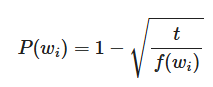


In [ ]:
def subsample_words(int_words, threshold = 1e-5):
    word_counts = Counter(int_words)
    total_n_words = len(int_words)

    freq_ratios = {word: count/total_n_words for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freq_ratios[word]) for word in word_counts}

    return [word for word in int_words if random.random() < (1 - p_drop[word])]

train_words = subsample_words(int_words)

In [ ]:
def get_target(words, idx, max_window_size=5):
    R = random.randint(1, max_window_size)
    start = max(0,idx-R)
    end = min(idx+R,len(words)-1)
    targets = words[start:idx] + words[idx+1:end+1] # +1 since doesn't include this idx
    return targets

In [ ]:
def get_batches(words, batch_size, max_window_size=5):
    # only full batches
    n_batches = len(words)//batch_size
    words = words[:n_batches*batch_size]
    for i in range(0, len(words), batch_size):
        batch_of_center_words = words[i:i+batch_size]   # current batch of words
        batch_x, batch_y = [], []

        for ii in range(len(batch_of_center_words)):  # range(batch_size) unless truncated at the end
            x = [batch_of_center_words[ii]]             # single word
            y = get_target(words=batch_of_center_words, idx=ii, max_window_size=max_window_size)  # list of context words

            batch_x.extend(x * len(y)) # repeat the center word (n_context_words) times
            batch_y.extend(y)

        yield batch_x, batch_y

In [ ]:
def cosine_similarity(embedding, n_valid_words=16, valid_window=100):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
      embedding: PyTorch embedding module
      n_valid_words: # of validation words (recommended to have even numbers)
    """
    all_embeddings = embedding.weight  # (n_vocab, n_embed)
    # sim = (a . b) / |a||b|
    magnitudes = all_embeddings.pow(2).sum(dim=1).sqrt().unsqueeze(0) # (1, n_vocab)

    # Pick validation words from 2 ranges: (0, window): common words & (1000, 1000+window): uncommon words
    valid_words = random.sample(range(valid_window), n_valid_words//2) + random.sample(range(1000, 1000+valid_window), n_valid_words//2)
    valid_words = torch.LongTensor(np.array(valid_words)).to(device) # (n_valid_words, 1)

    valid_embeddings = embedding(valid_words) # (n_valid_words, n_embed)
    # (n_valid_words, n_embed) * (n_embed, n_vocab) --> (n_valid_words, n_vocab) / 1, n_vocab)
    similarities = torch.mm(valid_embeddings, all_embeddings.t()) / magnitudes  # (n_valid_words, n_vocab)

    return valid_words, similarities

In [ ]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()

        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist

        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)

        # Initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)


    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors  # input vector embeddings


    def forward_target(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors  # output vector embeddings


    def forward_noise(self, batch_size, n_samples=5):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        # If no Noise Distribution specified, sample noise words uniformly from vocabulary
        if self.noise_dist is None:
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist

        # torch.multinomial :
        # Returns a tensor where each row contains (num_samples) **indices** sampled from
        # multinomial probability distribution located in the corresponding row of tensor input.
        noise_words = torch.multinomial(input       = noise_dist,           # input tensor containing probabilities
                                        num_samples = batch_size*n_samples, # number of samples to draw
                                        replacement = True)
        noise_words = noise_words.to(device)

        # use context matrix for embedding noise samples
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)

        return noise_vectors

In [ ]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):

        batch_size, embed_size = input_vectors.shape

        input_vectors = input_vectors.view(batch_size, embed_size, 1)   # batch of column vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size) # batch of row vectors

        # log-sigmoid loss for correct pairs
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log().squeeze()

        # log-sigmoid loss for incorrect pairs
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        return -(out_loss + noise_loss).mean()  # average batch loss

In [ ]:
# As defined in the paper by Mikolov et all.
freq = Counter(int_words)
freq_ratio = {word:cnt/len(vocab_to_int) for word, cnt in freq.items()}
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum()
noise_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75))

In [ ]:
"""class word2vec(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()

        self.embed = nn.Embedding(n_vocab, n_embed)
        self.fc1 = nn.Linear(n_embed, 64)
        self.fc2 = nn.Linear(64,32)
        self.output = nn.Linear(32, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embed(x)
        scores = F.relu(self.fc1(x))
        scores = F.relu(self.fc2(scores))
        scores = self.output(scores)
        log_ps = self.log_softmax(scores)

        return log_ps

In [ ]:
"""embedding_dim = 300

model = word2vec(len(word_to_id), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1000
steps = 0
epochs = 100

for e in range(epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # get input and target batches
    for inputs, targets in get_batches(subsampled_data, 512):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)

        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(log_ps, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

        if steps % print_every == 0:
            # getting examples and similarities
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [id_to_word[idx.item()] for idx in closest_idxs[ii]][1:]
                print(id_to_word[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

    # Calculate and print epoch-wise accuracy and loss
    epoch_accuracy = correct_predictions / total_predictions
    epoch_loss = total_loss / len(subsampled_data)  # Assuming subsampled_data is the entire dataset for this epoch

    print(f"Epoch {e + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

Epoch 1: Loss = 0.0126, Accuracy = 0.0903
often | triumph, sciences, enjoy, flagellates, samples
during | equator, notably, bounded, attempts, realm
them | organization, ethnography, rationalism, mathematician, grounding
other | important, unnamed, numerical, enquiry, rotate
world | parasites, hazard, familiar, motivated, retrieved
three | institute, square, legitimate, empiricists, indiana
than | spirituality, resistivity, states, rttemberg, philosophies
government | printable, covered, constellation, pieces, hay
covered | government, size, facial, savants, staying
understanding | trained, decoration, indicators, kentucky, rejecting
stated | pallas, security, numerous, foreign, individuals
collection | contains, served, ng, iraqi, informal
applied | precepts, flora, supreme, brownian, cook
victory | none, signals, advisor, pashtun, bertrand
forced | wherever, sanction, meteorites, terrier, sailed
nasa | continuing, di, perceived, opens, lsd
...
Epoch 2: Loss = 0.0119, Accuracy = 0.093

In [ ]:
embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int),
                                 embedding_dim,
                                 noise_dist )
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

In [ ]:
def train_skipgram(model, criterion, optimizer, int_words, n_negative_samples=5, batch_size=512, n_epochs=500, print_every=100):
  model.to(device)

  step = 0
  for epoch in range(n_epochs):
    for inputs, targets in get_batches(int_words, batch_size=batch_size):
      step += 1
      inputs = torch.LongTensor(inputs).to(device)    # [b*n_context_words]
      targets = torch.LongTensor(targets).to(device)  # [b*n_context_words]

      embedded_input_words = model.forward_input(inputs)
      embedded_target_words = model.forward_target(targets)
      embedded_noise_words = model.forward_noise(batch_size=inputs.shape[0],
                                                  n_samples=n_negative_samples)

      loss = criterion(embedded_input_words, embedded_target_words, embedded_noise_words)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (step % print_every) == 0:
        print("Epoch: {}/{}".format((epoch+1), n_epochs))
        print("Loss: {:.4f}".format(loss.item()))
        valid_idxs, similarities = cosine_similarity(model.in_embed)
        _, closest_idxs = similarities.topk(6)
        valid_idxs, closest_idxs = valid_idxs.to('cpu'), closest_idxs.to('cpu')

        for ii, v_idx in enumerate(valid_idxs):
          closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
          print(int_to_vocab[v_idx.item()] + " | "+ ", ".join(closest_words))

        print("\n...\n")

In [ ]:
train_skipgram(model, criterion, optimizer, int_words, n_negative_samples=5)

Streaming output truncated to the last 5000 lines.
...

Epoch: 420/500
Loss: 1.9205
united | states, kingdom, trucial, borders, arrived
three | zero, nine, four, two, one
for | tiger, of, tat, dating, simplest
five | zero, nine, six, one, four
four | nine, zero, hardcover, six, five
between | relationship, distinction, difference, dispute, gathering
world | oldest, factbook, domain, andorran, tropical
with | similarities, prefer, origin, enjoyed, join
fifth | concerto, ayers, fourth, halley, armenian
question | altruist, allow, logical, simply, starts
authority | feeling, melting, baseball, easier, originated
claims | showed, conservation, geographic, christianity, civilization
et | de, memory, al, la, frequency
greater | n, italian, habsburg, shown, descent
asphalt | tar, deposits, properties, syndrome, solid
rock | band, eclipsed, site, wing, russell

...

Epoch: 420/500
Loss: 1.9155
when | focuses, ball, dog, son, willing
would | expect, got, shall, wound, to
used | computers, desig

In [ ]:
embeddings = model.in_embed.weight.to('cpu').data.numpy()

In [ ]:
viz_words = 400
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

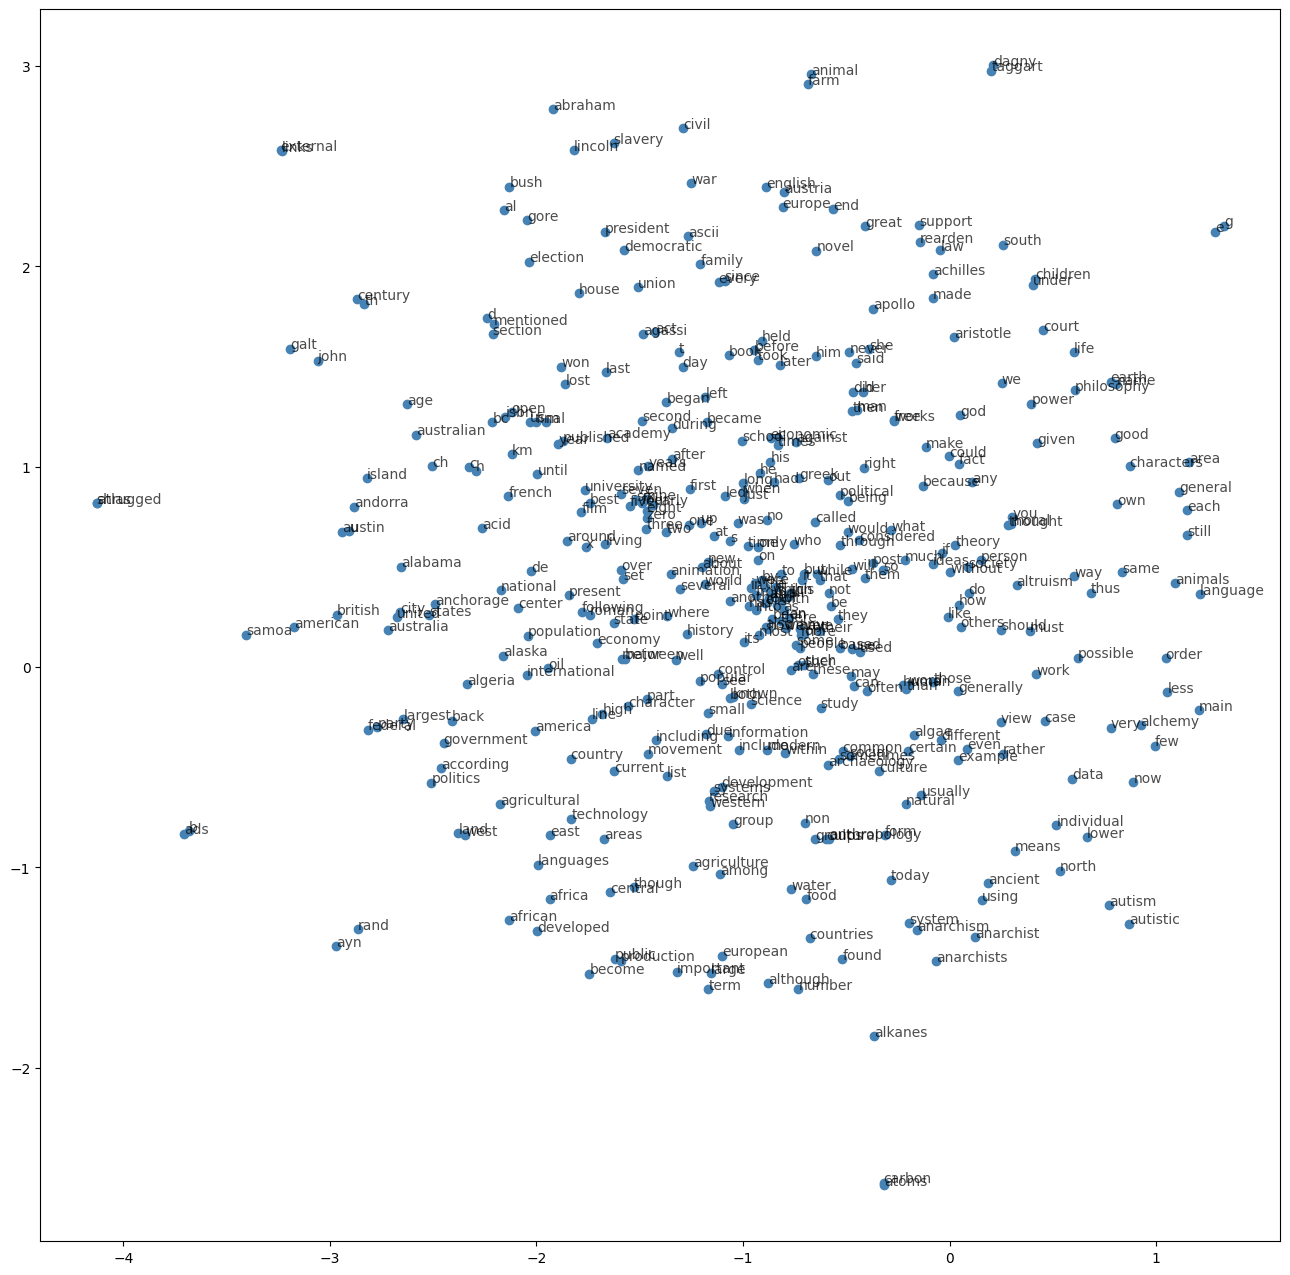

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)